# ResNet-50

## Introduction to ResNet (Residual Network)

__ResNet__ or __Residual Neural Network__ was proposed by researchers at Microsoft Research namely, _Kaiming He_, _Xiangyu Zhang_, _Shaoqing Ren_ and, _Jian Sun_; which also won [ImageNet](https://www.image-net.org/about.php) Challenge in 2015.

<center>
    <img src="./img/MicrosoftResearch.png" alt="Microsoft Research" width="500px"> <br>
</center>

In ResNet architecture, a *“shortcut”* or a *“skip connection”* allows the gradient to be directly backpropagated to earlier layers:
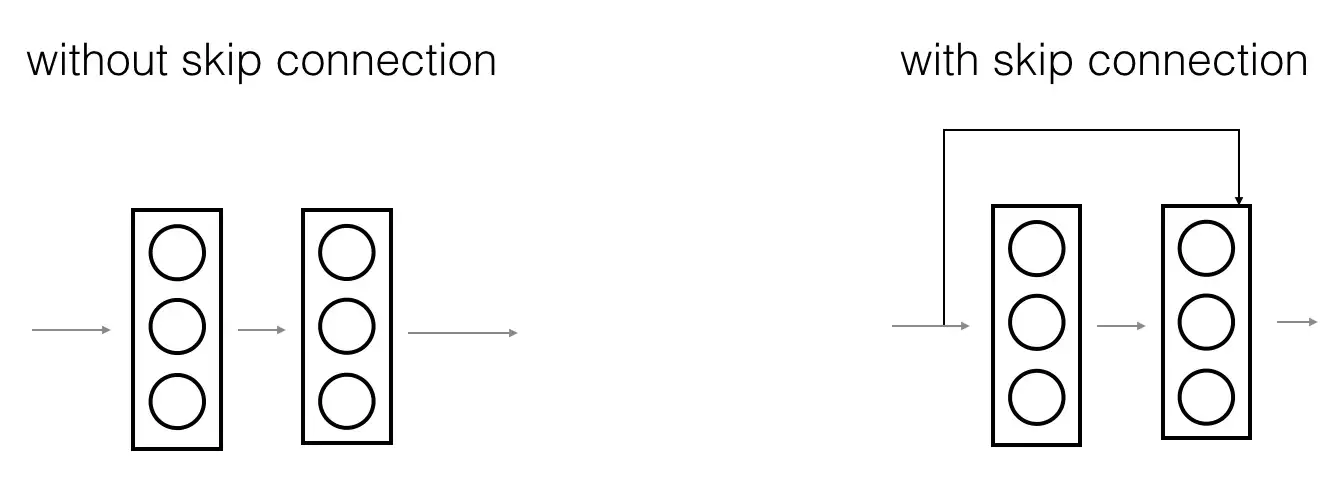

# ResNet-50 Implementation

## Importing Dependencies

In [ ]:
# Import OpenCV which is a Computer Vision library and here we use it to deal with our image dataset
import cv2

# Import NumPy as our model trains on arrays which will be handled by NumPy
import numpy as np

import scipy

# Import OS to interact with operating system
import os

# Import Math to use some mathematical computations
import math

# Import Shutil to move, copy and delete directories and sub-directories
import shutil

# Import glob module which finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
import glob

# Import mayplotlib and seaborn to visualize the metrics of our model
import matplotlib.pyplot as plt
import seaborn as sns

# Import Keras
import keras

# Import image from keras.preprocessing which is used the deal with dataset images while preprocessing them
from keras.preprocessing import image

# Import Keras ImageDataGenerator which is used for getting the input of the original data and further, it makes the transformation of this data on a random basis and gives the output resultant containing only the data that is newly transformed.
from keras.preprocessing.image import ImageDataGenerator

# Import scikit-learn metrics whivh will be used to display the metrics of the model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, PrecisionRecallDisplay, f1_score, roc_auc_score

# Import Keras layers
# Sequential class is used to build a model instance which will be constructed layer-by-layer (i.e., one layer is stacked over previous layer)
# Model class is used to initialize the instance of our CNN architecture (here ResNet50)
# load_model is uded to load the model from pre-existinf weights or models
from keras.models import Sequential, Model, load_model

# Import optimizers.Optimizer is an algorithm which is used for the learning of the model
# SGD (Stochastic Gradient Descent) is an optimization algorithm often used in machine learning applications to find the model parameters that correspond to the best fit between predicted and actual outputs.
from keras.optimizers import SGD

# Import EarlyStopping and ModelCheckpoint
# EarlyStopping is used to halt the learning of the used when the models accuracy does not improve by any significant amount
# ModelCheckpoint is used to save the model or weights in a checkpoint file at some time interval
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Import some Keras layers features which will be used to provide input to the layer, add layer to the model, perform pooling padding and convlution, flattening the image, and batch normalization
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, MaxPool2D

# Import glorot_uniform
# GlorotUniform draws samples from a uniform distribution within [-limit, limit] , where limit = sqrt(6 / (fan_in + fan_out)) ( fan_in is the number of input units in the weight tensor and fan_out is the number of output units).
from keras.initializers import glorot_uniform

# Import binary_crossentropy
# Binary cross entropy compares each of the predicted probabilities to actual class output which can be either 0 or 1. It then calculates the score that penalizes the probabilities based on the distance from the expected value. That means how close or far from the actual value.
from keras.losses import binary_crossentropy

## Splitting Dataset into Training, Validation and Testing

In [ ]:
DATASET_PATH = "Animal-Classification-Dataset"

In [ ]:
number_of_images = {}

# label the number of images in each class of our dadaset
for dir in os.listdir(DATASET_PATH):
    # os.listdir() is used to list or count the number of images in each directory of dataset
    # os.path.join() is used to join the parent directory, any subdirectory and the contents of the directory
    number_of_images[dir] = len(os.listdir(os.path.join(DATASET_PATH, dir)))

Randomly display any image from each class of the dataset

In [ ]:
# listing all the subdirectories in our main dataset directory
for dir in os.listdir(DATASET_PATH):
    # picking a random image from each class of the datset
    for img in np.random.choice(os.listdir(os.path.join(DATASET_PATH, dir)), size = 2):
        # read each image with the help of OpenCV
        image = cv2.imread(os.path.join(DATASET_PATH, dir, img))
        # plot the image using matplotlib
        plt.imshow(image); plt.axis("off")
        # give image a title using matplotlib
        plt.title(dir)
        # show or display the image using matplotlib
        plt.show()

___Listing the number of images in each class of our dataset___

In [ ]:
print("The dataset contains the following:")
for i, each_class in enumerate(number_of_images):
    print(f"{i + 1}) {number_of_images[each_class]} images of {each_class}")

In [ ]:
labels = []

for key in number_of_images.keys():
    labels.append(key)

print(labels)

### Declaring and Defining our Custom Function for Splitting the Dataset

In [ ]:
def data_folder(folder_name, split_ratio):
    """
    This function will split the dataset in a given number of new folders namely, Training, Testing and Validation in a given ratio.
    Such that Training:Testing:Validation = x:y:z
    Where,
        x is the number of images in Training Folder
        y is the number of images in Testing Folder
        z is the number of images in Validation Folder
    
    Arguments:
        folder_name: Name of the folder created for splitting the dataset
        split_ratio: Percentage of images of original dataset for every splitted folder_name
    """
    
    # checking if the folder does not already exist
    if not os.path.exists("./" + folder_name):
        # if the folder doesn't already exist then create that folder
        print(f"Creating {folder_name}")
        os.mkdir("./" + folder_name)
    
    # listing all the subdirectories in our main dataset directory
    for dir in os.listdir(DATASET_PATH):
        # checking if that subdirectory for this folder does not already exist
        if not os.path.exists("./" + folder_name + "/" + dir):
            # if it does not already exist then create that subdirectory for this folder
            print(f"Creating {dir} directory for {folder_name} folder")
            os.makedirs("./" + folder_name + "/" + dir)

        # picking random images from each class of the datset and copying it to the Training, Testing or Validation folder
        # size for each directory is the product of number of images in each class and the ratio of train, test, validate folders
        # For example: if Buffalo contains 1000 images and ratio train:test:validate = 70:15:15, then Testing folder will contain 700 images, Testing folder 150 images and Validation Folder 150 images 
        for img in np.random.choice(a = os.listdir(os.path.join(DATASET_PATH, dir)), size = (math.floor(split_ratio * number_of_images[dir])), replace = False):
            
            # pathname of original dataset
            O = os.path.join(DATASET_PATH, dir, img)
            
            # pathname of splitted dataset
            D = os.path.join("./" + folder_name, dir)
            
            # copy each image from original dataset path to splitted dataset path
            shutil.copy(O, D)
    
    else:
        print(f"{folder_name} folder exist")

___Creating Training Folder___

In [ ]:
data_folder("Training", 0.7)

___Creating Validation Folder___

In [ ]:
data_folder("Validation", 0.15)

___Creating Testing Folder___

In [ ]:
data_folder("Testing", 0.15)

In [ ]:
TRAIN_PATH = "./Training"

In [ ]:
TEST_PATH = "./Testing"

In [ ]:
VALIDATE_PATH = "./Validation"

___Listing the number of images in each class of our Training Folder___

In [ ]:
train_images = {}

# label the number of images in each class of our dadaset
for dir in os.listdir(TRAIN_PATH):
    # os.listdir() is used to list or count the number of images in each directory of dataset
    # os.path.join() is used to join the parent directory, any subdirectory and the contents of the directory
    train_images[dir] = len(os.listdir(os.path.join(TRAIN_PATH, dir)))

print("The Training folder contains the following:")
for i, each_class in enumerate(train_images):
    print(f"{i + 1}) {train_images[each_class]} images of {each_class}")

___Listing the number of images in each class of our Validation Folder___

In [ ]:
validate_images = {}

# label the number of images in each class of our dadaset
for dir in os.listdir(VALIDATE_PATH):
    # os.listdir() is used to list or count the number of images in each directory of dataset
    # os.path.join() is used to join the parent directory, any subdirectory and the contents of the directory
    validate_images[dir] = len(os.listdir(os.path.join(VALIDATE_PATH, dir)))

print("The Validation folder contains the following:")
for i, each_class in enumerate(validate_images):
    print(f"{i + 1}) {validate_images[each_class]} images of {each_class}")

___Listing the number of images in each class of our Testing Folder___

In [ ]:
test_images = {}

# label the number of images in each class of our dadaset
for dir in os.listdir(TEST_PATH):
    # os.listdir() is used to list or count the number of images in each directory of dataset
    # os.path.join() is used to join the parent directory, any subdirectory and the contents of the directory
    test_images[dir] = len(os.listdir(os.path.join(TEST_PATH, dir)))

print("The Testing folder contains the following:")
for i, each_class in enumerate(test_images):
    print(f"{i + 1}) {test_images[each_class]} images of {each_class}")

## Preprocessing Images

**ImageDataGenerator()** is used to perfrom augmentation on a given image. Augmentation means that the images are duplicated with some kind of variations that increase the size of the teraining set without aquiring new images.
Augmentation (or variations) that we performed here are the following:
- *zoom_range:* zoom in or zoom out images in a given range
- *width_shift_range:* shift the images horizontally in a given range
- *height_shift_range:* shift the images vertically in a given range
- *shear_range:* compress an vertically or horizontally in a given range, the oringinal image is somewhat distorted.

In [ ]:
train_data_generator = ImageDataGenerator(
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15
)

validate_data_generator = ImageDataGenerator()

test_data_generator = ImageDataGenerator()

***flow_from_directory()*** takes the path to a directory & generates batches of augmented data. <br>
**Arguments:**
- *directory:* string, or path to the directory.
- *target_size:* Tuple of integers (height, width), defaults to (256,256). The dimensions to which all images found will be resized.
- *batch_size:* Size of the batches of data (default: 32).
- *shuffle:*  Whether to shuffle the data (default: True) If set to False, sorts the data in alphanumeric order.
- *class_mode:* One of "categorical", "binary", "sparse", "input", or None. Default: "categorical". Determines the type of label arrays that are returned:
    - "categorical" will be 2D one-hot encoded labels,
    - "binary" will be 1D binary labels, "sparse" will be 1D integer labels

In [ ]:
train_generator = train_data_generator.flow_from_directory(
    directory = TRAIN_PATH,
    target_size = (224, 224),
    batch_size = 32,
    shuffle = True,
    class_mode = 'binary'
)

In [ ]:
train_generator.class_indices

In [ ]:
validate_generator = validate_data_generator.flow_from_directory(
    directory = VALIDATE_PATH,
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False,
    class_mode='binary'
)

In [ ]:
test_generator = test_data_generator.flow_from_directory(
    directory = TEST_PATH,
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False,
    class_mode='binary'
)

## Defining the Structure of ResNet50

### Identity Block
The identity block is the standard block used in ResNets and corresponds to the case where the input activation has the same dimension as the output activation.
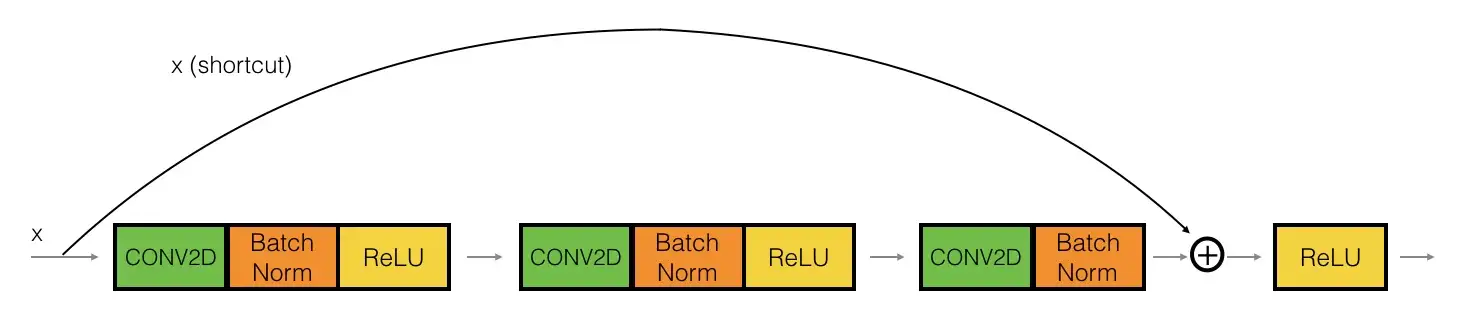

In [ ]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    # CONV2D
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    # ReLU
    X = Activation('relu')(X)

    # CONV2D
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    # ReLU
    X = Activation('relu')(X)

    # CONV2D
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # SKIP Connection
    X = Add()([X, X_shortcut])
    
    # ReLU
    X = Activation('relu')(X)

    return X

### Convolution Block
We can use this type of block when the input and output dimensions don’t match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path.
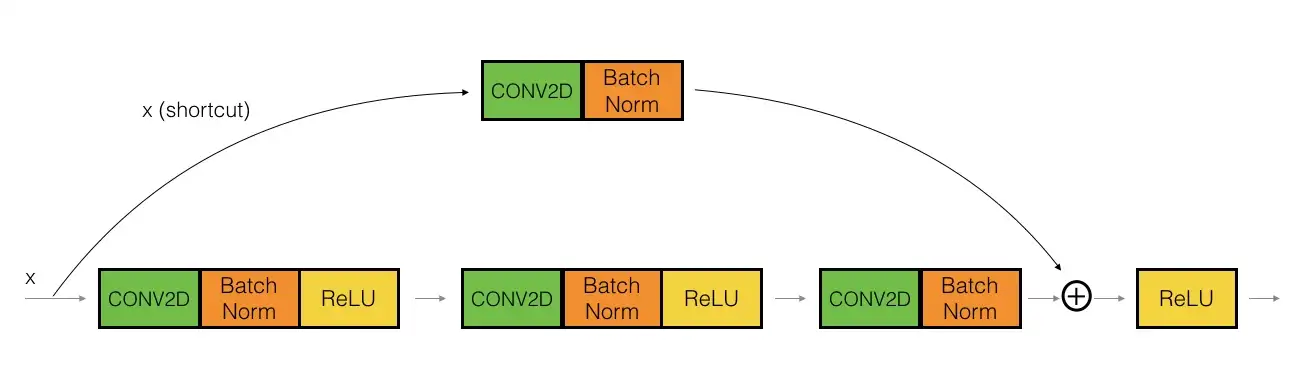

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    # CONV2D
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    # ReLU
    X = Activation('relu')(X)

    # CONV2D
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    # ReLU
    X = Activation('relu')(X)

    # CONV2D
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Shortcut CONV2D
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    # Shortcut Batch Norm
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Shortcut or Skip Connection
    X = Add()([X, X_shortcut])
    
    # ReLU
    X = Activation('relu')(X)

    return X

### ResNet-50
The ResNet-50 model consists of 5 stages each with a convolution and Identity block. Each convolution block has 3 convolution layers and each identity block also has 3 convolution layers. The ResNet-50 has over 23 million trainable parameters.
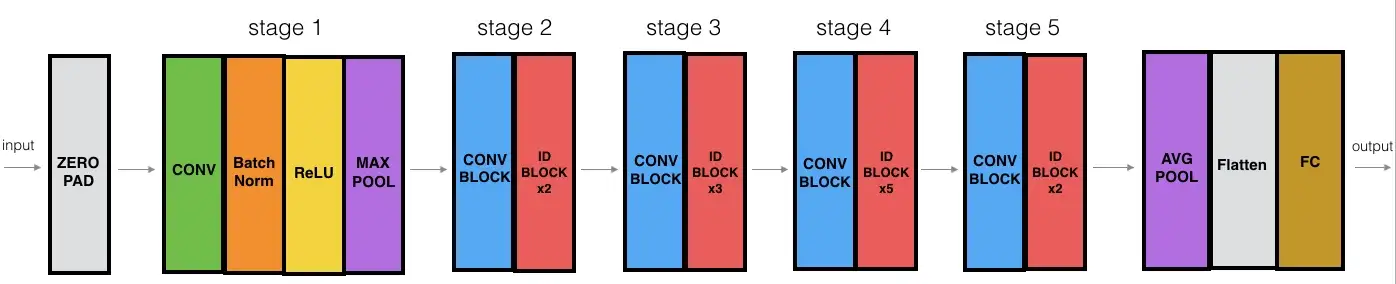

In [ ]:
def ResNet50(input_shape=(224, 224, 3)):

    # INPUT
    X_input = Input(input_shape)

    # ZERO PAD
    X = ZeroPadding2D((3, 3))(X_input)

    
    # stage 1
    
    # CONV
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    # Batch Norm
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    # ReLU
    X = Activation('relu')(X)
    # MAX POOL
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    
    # stage 2
    
    # CONV BLOCK
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    # ID BLOCK x2
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    
    # stage 3
    
    # CONV BLOCK
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    # ID BLOCK x3
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    
    # stage 4
    
    # CONV BLOCK
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    # ID BLOCK x5
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    
    # stage 5
    
    # CONV BLOCK
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    # ID BLOCK x2
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVG POOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    # return ResNet50 as model
    return model

In [ ]:
base_model = ResNet50(input_shape=(224, 224, 3))

In [ ]:
head_model = base_model.output

# Flatten the output of our model
head_model = Flatten()(head_model)

# Constructing fully connected layer
head_model = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(head_model)
head_model = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(head_model)
head_model = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(head_model)

In [ ]:
model = Model(inputs=base_model.input, outputs=head_model)

In [ ]:
model.summary()

### `compile` method
Configures the model for training.
#### *Arguments*
- **optimizer:** String (name of optimizer) or optimizer instance.
- **loss:** Loss function. May be a string (name of loss function), or a `keras.losses` instance.
- **metrics:** List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a keras.metrics instance.

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

## Defining and Initializing Callbacks for our Model

### Early Stopping
Stop training when a monitored metric has stopped improving.

Assuming the goal of a training is to maximize the validation accuracy. With this, the metric to be monitored would be 'val_accuracy', and mode would be 'max'.

#### *Arguments*
- **monitor:** Quantity to be monitored.
- **min_delta:** Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
- **mode:** One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
- **verbose:** Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
- **patience:** Number of epochs with no improvement after which training will be stopped.

In [ ]:
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.01,
    mode = 'max',
    verbose = 1,
    patience = 20
)

### Model Checkpoint
ModelCheckpoint() callback is used in conjunction with training using model.fit() or model.fit_generator to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

A few options this callback provides include:
- Whether to only keep the model that has achieved the "best performance" so far, or whether to save the model at the end of every epoch regardless of performance.
- Definition of 'best'; which quantity to monitor and whether it should be maximized or minimized.
- The frequency it should save at. Currently, the callback supports saving at the end of every epoch, or after a fixed number of training batches.
- Whether only weights are saved, or the whole model is saved.

#### *Arguments*
- **filepath:** string or, path to save the model file.
- **monitor:** The metric name to monitor.
    - Prefix the name with "val_" to monitor validation metrics.
    - Use "loss" or "val_loss" to monitor the model's total loss.
    - If you specify metrics as strings, like "accuracy", pass the same string (with or without the "val_" prefix).
- **save_best_only:** if save_best_only=True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
- **mode:** one of {'auto', 'min', 'max'}. If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_accuracy, this should be max, for val_loss this should be min, etc. In auto mode, the mode is set to max if the quantities monitored are 'accuracy' and are set to min for the rest of the quantities.

In [ ]:
model_checkpoint = ModelCheckpoint(
    filepath = './model/best_model.h5',
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True
)

### model.fit_generator()
*(Deprecated) Fits the model on data yielded batch-by-batch by a generator.* <br>
The generator is run in parallel to the model, for efficiency. For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU. If we have a large dataset that cannot be loaded in the RAM at once, fit_generator() is the recommended way of working.

#### *Arguments*
- **generator:** A generator (e.g. like the one provided by `flow_from_directory()`).
    The output of the generator must be a list of one of these forms:
    ```
    - (inputs, targets)
    - (inputs, targets, sample_weights)
    ```
    This list (a single output of the generator) makes a single batch.
- **validation_data:** this can be either:
    - a generator for the validation data
    - a list (inputs, targets)
    - a list (inputs, targets, sample_weights). on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data.
- **steps_per_epoch:** Total number of steps (batches of samples) to yield from `generator` before declaring one epoch finished and starting the next epoch. It should typically be equal to the number of samples if your dataset divided by the batch size.
- **epochs:** Integer. Number of epochs to train the model. An epoch is an iteration over the entire data provided, as defined by `steps_per_epoch`.
- **verbose:** Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch).
- **callbacks:** List of callbacks to apply during training.

In [ ]:
model_history = model.fit_generator(
    generator = train_generator,
    validation_data = validate_generator,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping, model_checkpoint]
)

#### Plotting Accuracy vs Validation Accuracy

In [ ]:
sns.set()

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'], c='red')

plt.title("Accuracy vs Validation Accuracy")
plt.show()

#### Plotting Loss vs Validation Loss

In [ ]:
sns.set()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'], c='red')

plt.title("Loss vs Validation Loss")
plt.show()

### model.load_weights()
Loads all layer weights from a saved files.
#### *Arguments*
- **filepath:** String, path to the weights file to load.

In [ ]:
model.load_weights("./model/best_model.h5")

### model.evaluate_generator()
*(Deprecated)* Evaluates the model on a data generator.

In [ ]:
evaluation = model.evaluate_generator(test_generator)

print(f"The accuracy of our model on Testing Data is {(evaluation[1] * 100):.3f}%")

### model.predict_generator()
*(Deprecated)* Generates predictions for the input samples from a data generator.
#### *Arguments*
- **generator:** Generator yielding batches of input samples.
- **steps:** Total number of steps (batches of samples) to yield from `generator` before stopping.
- **verbose:** verbosity mode, 0 or 1.
- **workers:** Maximum number of threads to use for parallel processing.

In [ ]:
predictions = model.predict_generator(
    generator = test_generator,
    steps = np.ceil(test_generator.samples / test_generator.batch_size),
    verbose = 0,
    workers = 0
)

In [ ]:
print(predictions)

In [ ]:
# number of images in our testing dataset
test_generator.samples

In [ ]:
# batch size for testing data generator
test_generator.batch_size

In [ ]:
# store the predicted outcomes of our model

# if the prediction probability is greater than 0.5, then it belongs to class 0 (i.e., Zebra) otherwise class 1 (i.e., Buffalo)
predicted_classes = np.where(predictions > 0.5, 1, 0)

print(predicted_classes)

In [ ]:
# classes found in our testing data generator
print(test_generator.classes)

## Metrics for our ResNet-50 Convolutional Neural Network

### Confustion Matrix

In [ ]:
c_m = confusion_matrix(test_generator.classes, predicted_classes)

In [ ]:
sns.set_style("ticks")

# Setting default size of the plot
# Setting default fontsize used in the plot
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20


# Implementing visualization of Confusion Matrix
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=labels)


# Plotting Confusion Matrix
# Setting colour map to be used
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Setting fontsize for xticks and yticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Giving name to the plot
plt.title('Confusion Matrix', fontsize=24)


# Saving plot
plt.savefig('confusion_matrix.png', transparent=True, dpi=500)

# Showing the plot
plt.show()

### Classification Report

In [ ]:
print("Classification Report containes the following metrics:\n")
print(classification_report(test_generator.classes, predicted_classes, target_names = ['Buffalo', 'Zebra']))

### Precission-Recall Curve

In [ ]:
precision, recall, threshold = precision_recall_curve(test_generator.classes, predictions)

In [ ]:
sns.set()

PrecisionRecallDisplay(
    precision = precision,
    recall = recall,
    average_precision = average_precision,
    estimator_name = "ResNet-50 Convolution Neural Network"
).plot(marker = ".")

plt.show()

### ROC-AUC Curve

In [ ]:
from sklearn.metrics import auc, roc_auc_score, roc_curve, RocCurveDisplay

false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, predictions)

RocCurveDisplay(
    fpr = false_positive_rate,
    tpr = true_positive_rate,
    roc_auc = auc(false_positive_rate, true_positive_rate),
    estimator_name = "ResNet-50 Convolution Neural Network"
).plot(marker = ".")

plt.show()

## Perform Prediction on Some Random Images

### model.predict()
Generates output predictions for the input samples.
#### *Arguments*
- **x:** Input samples. It could be:
    - A Numpy array (or array-like), or a list of arrays (in case the model has multiple inputs).
    - A TensorFlow tensor, or a list of tensors (in case the model has multiple inputs).
    - A generator

### numpy.expand_dims() 
Expand the shape of an array. <br>
Insert a new axis that will appear at the axis position in the expanded array shape.
#### *Arguments*
- **a:** *array_like* <br> Input array.
- **axis:** *int or tuple of ints* <br> Position in the expanded axes where the new axis (or axes) is placed.

In [ ]:
def predict_image(image_path):
    """
    This function will take image path as an argument and predict whether it is a buffalo or zebra.
    
    Arguments:
        image_path: string, or path of the image where it is located.
    """
    
    # read the image from image_path with the help of OpenCV
    image = cv2.imread(image_path)
    # resize the image to (224, 224) as our model accepts the input of size (224, 224)
    resized_image = cv2.resize(image, (224, 224))
    
    prediction = model.predict(np.expand_dims(a = resized_image, axis = 0), verbose = 0)
    
    if prediction < 0.5:
        print("Predicted Label: Buffalo")
    else:
        print("Predicted Label: Zebra")
    
    plt.imshow(image); plt.axis("off")
    plt.show()

In [ ]:
# list all the directories in our main dataset path
for directory in os.listdir(DATASET_PATH):
    # pick a single random image from each sub-directory of main dataset path
    for img in np.random.choice(os.listdir(os.path.join(DATASET_PATH, directory)), size = 1):
        # perform prediction on each image that is being chosen
        predict_image(os.path.join(DATASET_PATH, directory, img))
        print("\n\n")